# Benchmark Brax Rendering Example using JaxRenderer backend

Self-link: https://www.kaggle.com/joeyteng/benchmark-jaxrenderer-32x32

Benchmarking using TPU v3-8 on micro canvas (84x84): https://www.kaggle.com/joeyteng/benchmark-jaxrenderer-84x84

Benchmarking using T4 on micro canvas (84x84): https://colab.research.google.com/drive/1Pa5OBHAGmKnuVhvTvgsIhPYJ1WNhdfE6

Benchmarking using A100 on micro canvas (84x84):: https://colab.research.google.com/drive/1-lToQZ3ZGAVQrnHy39JfneM9iT2HOfaT

Benchmarking using T4 on small canvas: https://colab.research.google.com/drive/1X_IbG5SGdQ_GnsjjlBaF9pJQR7vu8Aml

Benchmarking using A100 on small canvas: https://colab.research.google.com/drive/1Mr2pRetdobZdgdtNT_DJuS4YZq3-C4oY

Benchmarking using A100 on larger canvas: https://colab.research.google.com/drive/1A7PzhG3vn6oNzrWTxE5E3dmu8xQTcNnH

Benchmarking using T4, and baseline (CPU PyTinyrenderer): https://colab.research.google.com/drive/1xhkYNz5WjvUCjQWpp72CLf9SIy3i5PnN

Generate data: https://colab.research.google.com/drive/1c_83TLtb_pOt4OSlWFQgIKzA9DxdBDTp

<details>
  <summary>Other related profiling/benchmarking Colabs</summary>

Profile with pre-generated data: https://colab.research.google.com/drive/12yNBVOdwUqUOBRgmQHF0gl8eMzzIi_BH

Previous profile version (profile branch head): https://colab.research.google.com/drive/1V7gdTY6ZYz7YhJI_LCWLZM035zSDTYoQ

Previous prfiling version: https://colab.research.google.com/drive/1BJQG38IHPaUuMKMnNeq0hjrLtqwx4OfU

All-inlines + minibatch loops: https://colab.research.google.com/drive/1NiCTOCxfU0Mvr818Zqt4y63-S20Gn8yb

All-inlines: https://colab.research.google.com/drive/1Wrt3a0yoVPhYUJYCZltFIYoELWD-ciE0

Baseline link: https://colab.research.google.com/drive/17NSjyJL_Ov9D32Mnrs7miZmjiPNf9U6l

</details>

The sample output is using TPU VM v3-8 backend.

## Install Dependencies

In [1]:
!pip uninstall jaxrenderer -y -qqq
!pip install git+https://github.com/JoeyTeng/jaxrenderer.git@v0.3.1 -qqq

## Imports

In [2]:
from functools import partial
from typing import List, Optional
from platform import python_version
import pickle

import jax
from jax import numpy as jp
from jax.sharding import Mesh
from jax.experimental.maps import xmap
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from scipy.spatial.transform import Rotation as R

print("JAX Version:", jax.__version__)
print("Python Version:", python_version())
print(f"devices ({jax.device_count()}):")

from tqdm.auto import tqdm

from renderer import CameraParameters as Camera
from renderer import LightParameters as Light
from renderer import ModelObject as Instance
from renderer import ShadowParameters as Shadow
from renderer import Renderer, transpose_for_display

jax.devices()

JAX Version: 0.4.6
Python Version: 3.8.17
devices (8):


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Load data and define constants

In [3]:
!rm inputs-30.zip inputs.pickle >/dev/null 2>&1
!wget -q https://github.com/JoeyTeng/jaxrenderer/raw/92904b74f4d760cd66b8940ed41c2d854cfbebe9/test_resources/pre-gen-brax/inputs-30.zip -O inputs-30.zip
!unzip -q inputs-30.zip

FRAMES_AVAILABLE: int = 30

_batched_instances, _batched_camera, _batched_target = pickle.load(open("inputs.pickle", "rb"))

canvas_width: int = 32 #@param {type:"integer"}
canvas_height: int = 32 #@param {type:"integer"}

_batched_instances = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_instances)
_batched_camera = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_camera)
_batched_target = jax.tree_map(lambda a: jp.asarray(a).block_until_ready(), _batched_target)

## Utility Function

In [4]:
#@title ## Utility Function
import gc
import itertools
import time
from typing import Any, Callable


def benchmark(
    f: Callable[[], Any],
    repeat: int = 2,
    number: int = 1,
    sort: bool = True,
) -> List[int]:
  """Execute given pure function `f` `number` times and take sum, repeat for
    `repeat` times.

  In total, f is executed repeat * number times.

  This function is a very similar re-implementation of `timeit.repeat`.

  Parameters:
    - f: Pure function to be tested, taking no parameter and returns nothing.
      Return value is ignored. This function must be safe to reentrancy.
    - repeat: int, default 2.
    - number: int, default 1.
    - sort: bool, default True. Whether to sort result timings (in ascending
      order)

  Return:
    a list of total execution times, in nanoseconds. The size of the results
    equals to `repeat`.
  """
  result: List[int] = []

  for _ in range(repeat):
    it = itertools.repeat(None, number)
    gcold = gc.isenabled()
    gc.disable()

    try:
      _t_before: int = time.perf_counter_ns()
      for _ in it:
        f()
      _t_after: int = time.perf_counter_ns()
    finally:
      if gcold:
        gc.enable()

    result.append(_t_after - _t_before)

  if sort:
    result.sort()

  return result


def plot(seriesA: pd.Series, seriesB: pd.Series, title: str, ylabel: str, xlabel: str = "num frames"):
  fig, ax = plt.subplots()
  ax.plot(seriesA, label=seriesA.name, color="#39C5BB")
  ax.plot(seriesB, label=seriesB.name, color="#FFA500")
  ax.grid()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  fig.legend()

## Experiment - JaxRenderer with TPU

### Render Function

In [5]:
#@title ### Render function
def profile_compile(batched_instances, batched_camera, batched_target, loop_unroll: int = 1):
  """Return cost analysis. states is batched."""
  @jax.default_matmul_precision("float32")
  def render_instances(
    instances: List[Instance],
    width: int,
    height: int,
    camera: Camera,
    light: Optional[Light] = None,
    shadow: Optional[Shadow] = None,
    camera_target: Optional[jp.ndarray] = None,
    enable_shadow: bool = True,
  ) -> jp.ndarray:
    """Renders an RGB array of sequence of instances.

    Rendered result is not transposed with `transpose_for_display`; it is in
    floating numbers in [0, 1], not `uint8` in [0, 255].
    """
    if light is None:
      direction = jp.array([0.57735, -0.57735, 0.57735])
      light = Light(
          direction=direction,
          ambient=0.8,
          diffuse=0.8,
          specular=0.6,
      )
    if shadow is None and enable_shadow:
      assert camera_target is not None, 'camera_target is None'
      shadow = Shadow(centre=camera_target)
    elif not enable_shadow:
      shadow = None

    img = Renderer.get_camera_image(
      objects=instances,
      light=light,
      camera=camera,
      width=width,
      height=height,
      shadow_param=shadow,
      loop_unroll=loop_unroll,
    )
    arr = jax.lax.clamp(0., img, 1.)

    return arr

  def _render(instances, camera, target) -> jp.ndarray:
    _render = jax.jit(
      render_instances,
      static_argnames=("width", "height", "enable_shadow"),
      inline=True,
    )
    img = _render(instances=instances, width=canvas_width, height=canvas_height, camera=camera, camera_target=target)
    arr = transpose_for_display((img * 255).astype(jp.uint8))

    return arr
  
  def _compile_render_batch_then_remainder(instances, cameras, targets) -> Callable[[Any, Any, Any], Any]:
    batch_size: int = targets.shape[0]
    frames_per_batch: int = jax.device_count()
    batches: int = batch_size // frames_per_batch
    remainder: int = batch_size % frames_per_batch
    batched: int = batch_size - remainder

    args = (instances, cameras, targets)

    with Mesh(jax.devices(), ("x", )):
      _batch_params = jax.tree_map(lambda param: jax.tree_map(lambda field: field[:batched], param), args)
      _remainder_params = jax.tree_map(lambda param: jax.tree_map(lambda field: field[batched:], param), args)

      # axis_mapping = {0: "batch"}
      if batched > 0:
        axis_mapping = ["x", ...]
        _render_batch = xmap(_render, in_axes=[axis_mapping] * 3, out_axes=axis_mapping, axis_resources={"x": "x"})
        _render_batch_compiled = _render_batch.lower(*_batch_params).compile()

      if remainder > 0:
        with Mesh(jax.devices()[:remainder], ("y", )):
          axis_mapping = ["y", ...]
          _render_remainder = xmap(_render, in_axes=[axis_mapping] * 3, out_axes=axis_mapping, axis_resources={"y": "y"})
          _render_remainder_compiled = _render_remainder.lower(*_remainder_params).compile()

    def _execute(instances, cameras, targets) -> jp.ndarray:
      args = (instances, cameras, targets)
      if batched > 0:
        batch_ = _render_batch_compiled(*jax.tree_map(lambda param: jax.tree_map(lambda field: field[:batched], param), args))
      if remainder > 0:
        remainder_ = _render_remainder_compiled(*jax.tree_map(lambda param: jax.tree_map(lambda field: field[batched:], param), args))

      if batched > 0 and remainder > 0:
        result = jax.tree_map(lambda a, b: jax.lax.concatenate((a, b), 0), jax.device_get(batch_), jax.device_get(remainder_))
      elif batched > 0:
        result = batch_
      else:
        result = remainder_

      return result

    return _execute

  _render_compiled = _compile_render_batch_then_remainder(batched_instances, batched_camera, batched_target)

  return _render_compiled

### Loop Unroll

In [9]:
loop_unroll_cases: List[int] = [1, 2, 4, 8, 16, 32]
    
# benchmarking
# render 30 frames per batch
batched_instances = _batched_instances
batched_camera = _batched_camera
batched_target = _batched_target

timings = onp.zeros((len(loop_unroll_cases), 2), dtype=int)
column_indices = ["execution (min)", "execution (max)"]
row_indices = loop_unroll_cases.copy()

for i, loop_unroll in tqdm(enumerate(loop_unroll_cases), total=len(loop_unroll_cases)):
  _render_batch_compiled = profile_compile(batched_instances, batched_camera, batched_target, loop_unroll=loop_unroll)

  ts = benchmark(lambda: _render_batch_compiled(batched_instances, batched_camera, batched_target).block_until_ready(), repeat=7)
  # only take the minimum/maximum time
  timings[i, 0] = ts[0]
  timings[i, 1] = ts[-1]

100%|██████████| 6/6 [07:05<00:00, 70.88s/it] 


,execution (min),execution (max)
1,736871278,1072568063
2,730987645,845885007
4,723836065,853584018
8,714490876,860198994
16,737430095,903832346
32,717263637,975756251


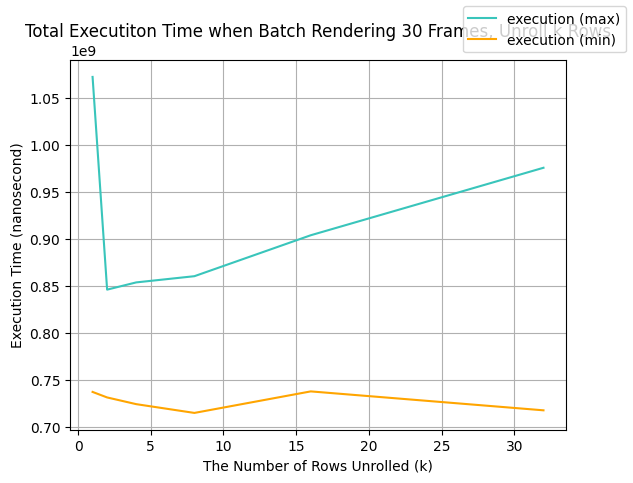

In [10]:
# visualisation

df_unroll = pd.DataFrame(timings[:, :2], index=row_indices, columns=column_indices)
display(df_unroll)

plot(
    df_unroll[column_indices[1]],
    df_unroll[column_indices[0]],
    title="Total Executiton Time when Batch Rendering 30 Frames, Unroll k Rows",
    ylabel="Execution Time (nanosecond)",
    xlabel="The Number of Rows Unrolled (k)"
)

,max fps,min fps
1,40.712674,27.970253
2,41.040365,35.465814
4,41.445849,35.145925
8,41.987940,34.875651
16,40.681822,33.191996
32,41.825625,30.745383


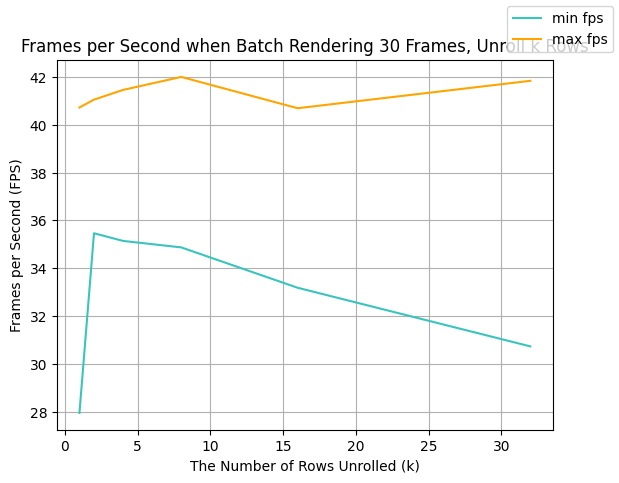

In [11]:
df_unroll_fps = pd.DataFrame(1 / (timings[:, :2] / 10**9 / FRAMES_AVAILABLE), index=loop_unroll_cases, columns=("max fps", "min fps"))
display(df_unroll_fps)

plot(
    df_unroll_fps["min fps"],
    df_unroll_fps["max fps"],
    title="Frames per Second when Batch Rendering 30 Frames, Unroll k Rows",
    ylabel="Frames per Second (FPS)",
    xlabel="The Number of Rows Unrolled (k)"
)

### Unroll = 2, number of frames

In [12]:
#@title Benchmarking
loop_unroll: int = 2
num_frames = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
frames_per_batch = FRAMES_AVAILABLE

num_frames_timings = onp.zeros((len(num_frames), 2), dtype=int)
column_indices = ["execution (min)", "execution (max)"]
row_indices = num_frames.copy()

batched_instances = _batched_instances
batched_camera = _batched_camera
batched_target = _batched_target


for i, num_frame in tqdm(enumerate(num_frames), total=len(num_frames)):
  # prepare data
  def prepare_data(param):
    batched = jax.tree_map(
        lambda field: jax.lax.concatenate(
            [field] * (num_frame // field.shape[0]) + [field[:(num_frame % field.shape[0])]],
            0,
        ).block_until_ready(),
        param,
    )

    return batched

  batched_instances = prepare_data(_batched_instances)
  batched_camera = prepare_data(_batched_camera)
  batched_target = prepare_data(_batched_target)

  # benchmark
  _render_batch_compiled = profile_compile(batched_instances, batched_camera, batched_target, loop_unroll=loop_unroll)
  times = num_frame // frames_per_batch
  ts = benchmark(lambda: _render_batch_compiled(batched_instances, batched_camera, batched_target).block_until_ready(), repeat=7)

  # only take the minimum/maximum time
  num_frames_timings[i, 0] = ts[0]
  num_frames_timings[i, 1] = ts[-1]

100%|██████████| 21/21 [13:35<00:00, 38.85s/it]


,execution (min),execution (max)
1,75631094,115941423
2,139010551,514976165
3,145762874,590740274
4,163437377,689787941
5,175296115,697368106
6,188794001,463183605
7,199918621,733845131
8,218343825,1128026342
9,552586195,1581594173
10,629967181,1843479493


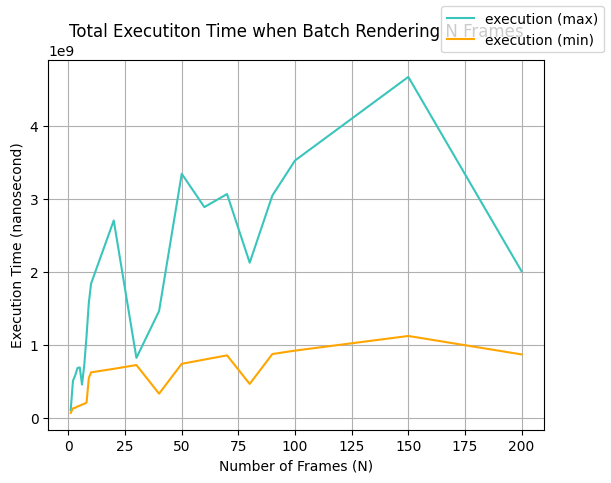

In [13]:
df_time = pd.DataFrame(num_frames_timings, index=row_indices, columns=column_indices)
display(df_time)

plot(
    df_time[column_indices[1]],
    df_time[column_indices[0]],
    title="Total Executiton Time when Batch Rendering N Frames",
    ylabel="Execution Time (nanosecond)",
    xlabel="Number of Frames (N)"
)

,max fps,min fps
1,13.222075,8.625045
2,14.387397,3.883675
3,20.581372,5.078374
4,24.474206,5.798884
5,28.523165,7.169815
6,31.780671,12.953826
7,35.014247,9.538797
8,36.639461,7.092033
9,16.287052,5.690461
10,15.873843,5.424525


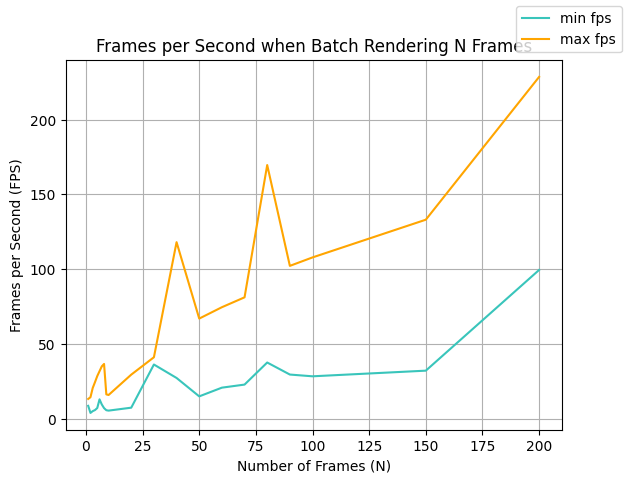

In [14]:
df_fps = pd.DataFrame(1 / (num_frames_timings / 10**9 / onp.array(num_frames)[:, None]), index=row_indices, columns=("max fps", "min fps"))
display(df_fps)

plot(
    df_fps['min fps'],
    df_fps['max fps'],
    title="Frames per Second when Batch Rendering N Frames",
    ylabel="Frames per Second (FPS)",
    xlabel="Number of Frames (N)",
)